In [24]:
import librosa
import librosa.display
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import import_ipynb
import Feature_Engineering

In [25]:
spectrogram_dir = "generes_spectrograms"
categories = os.listdir(spectrogram_dir)

In [26]:
data = []
labels = []

In [27]:
for category in categories:
    category_path = os.path.join(spectrogram_dir, category)
    for file in os.listdir(category_path):
        file_path = os.path.join(category_path, file)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) 
        image = cv2.resize(image, (128, 128))
        image = image / 255.0 
        data.append(image)
        labels.append(category)

In [28]:
featured_data = np.array([Feature_Engineering.feature_engineering(img) for img in data])

In [29]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(featured_data, labels_onehot, test_size=0.2, random_state=42)

In [31]:
X_test.shape

(200, 128, 128, 3)

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model_fit_featured = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50, batch_size=32)

Epoch 1/50
25/25 [==============================] - 19s 625ms/step - loss: 2.7067 - accuracy: 0.1114 - val_loss: 2.2931 - val_accuracy: 0.0600
Epoch 2/50
25/25 [==============================] - 22s 867ms/step - loss: 2.2666 - accuracy: 0.1114 - val_loss: 2.2472 - val_accuracy: 0.1450
Epoch 3/50
25/25 [==============================] - 21s 867ms/step - loss: 2.1867 - accuracy: 0.1740 - val_loss: 2.1940 - val_accuracy: 0.1450
Epoch 4/50
25/25 [==============================] - 19s 756ms/step - loss: 2.1473 - accuracy: 0.1927 - val_loss: 2.1888 - val_accuracy: 0.1350
Epoch 5/50
25/25 [==============================] - 21s 860ms/step - loss: 2.1118 - accuracy: 0.2278 - val_loss: 2.1439 - val_accuracy: 0.1750
Epoch 6/50
25/25 [==============================] - 21s 825ms/step - loss: 2.0839 - accuracy: 0.2453 - val_loss: 2.1111 - val_accuracy: 0.2100
Epoch 7/50
25/25 [==============================] - 21s 859ms/step - loss: 2.0283 - accuracy: 0.2553 - val_loss: 2.0715 - val_accuracy: 0.2800

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 [==============================] - 1s 222ms/step - loss: 2.4618 - accuracy: 0.4350
Test Loss: 2.4618
Test Accuracy: 0.4350


In [12]:
model.save("cnn_featured_model.h5")

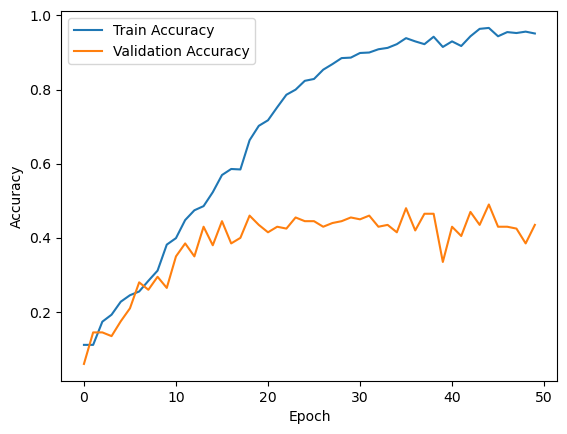

In [13]:
plt.plot(model_fit_featured.history['accuracy'], label='Train Accuracy')
plt.plot(model_fit_featured.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

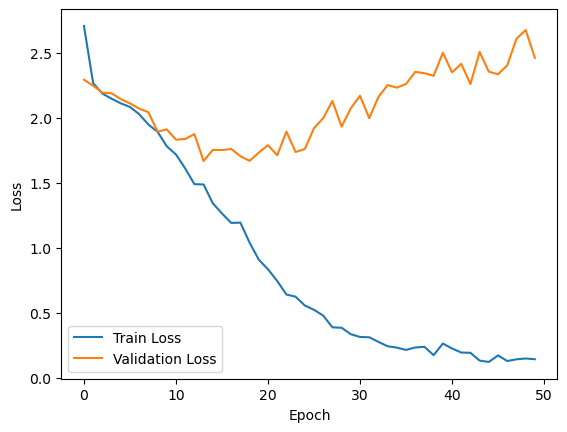

In [14]:
plt.plot(model_fit_featured.history['loss'], label='Train Loss')
plt.plot(model_fit_featured.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

import librosa
import numpy as np
import cv2
from tensorflow.keras.models import load_model

cnn_model = load_model("cnn_featured_model.h5")

In [2]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [33]:
import librosa
import numpy as np
import cv2
from tensorflow.keras.models import load_model

cnn_model = load_model("cnn_featured_model.h5")  
categories = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

def audio_to_spectrogram(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr, duration=30)
    
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    mel_spec_db = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))

    mel_spec_resized = cv2.resize(mel_spec_db, (128, 128))
    
    mel_spec_input = np.stack([mel_spec_resized] * 3, axis=-1)  
    mel_spec_input = np.expand_dims(mel_spec_input, axis=0) 
    
    return mel_spec_input

def predict_genre_from_audio(file_path):
    input_data = audio_to_spectrogram(file_path)

    prediction = model.predict(input_data)

    predicted_category = categories[np.argmax(prediction)]
    return predicted_category

file_path = "C:\\Users\\srira\\OneDrive\\Desktop\\Fall 24\\Feature Engineering\\Project\\generes_raw\\classical\\classical.00000.wav"  # Replace with your audio file path
predicted_category = predict_genre_from_audio(file_path)
print(f"Predicted Category: {predicted_category}")


1/1 [==============================] - 5s 5s/step
Predicted Category: reggae
